In [1]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

/var/folders/rx/0shr4jt1365bgrnlk6fkmjjh0000gn/T/ipykernel_24989/865703963.py:1: DtypeWarning: Columns (179,180,182,183,189,190,197,198,203,204,205,206,222,224,226,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  play2024_df = pd.read_csv("data/play_by_play_2024.csv")


In [4]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [5]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [6]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [7]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [8]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [9]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [10]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

### Modeling

In [11]:
# dropping meta data columns
play2024_df = play2024_df.drop(columns=["play_id","game_id","old_game_id"])

In [12]:
X = play2024_df.drop(columns=['was_injured', "missed_time"])  # Drop the target column
y = play2024_df['was_injured']  # Target column

In [13]:
# Lambda function to extract day and month
def extract_day_month(X):
    X = X.copy()
    X['date'] = pd.to_datetime(X['date'])
    X['month'] = X["date"].dt.month
    X['day'] = X["date"].dt.day
    return X.drop(columns=["date"])

In [14]:
date_transformer = Pipeline(steps=[
    ('extract_day_month', FunctionTransformer(lambda X: extract_day_month(X)))
])

In [15]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

# Handling missing values and encoding
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical data with mean
    ('scaler', StandardScaler())                 # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                     # One-hot encode categorical variables
])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('date', date_transformer, ["date"])  # Simple date transformation
    ]
)

In [17]:
X_preprocessed = preprocessor.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.1, stratify=y, random_state=42
)

In [19]:
print("Train Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Train Target Distribution:", y_train.value_counts())
print("Test Target Distribution:", y_test.value_counts())

Train Features Shape: (23710, 104934)
Test Features Shape: (2635, 104934)
Train Target Distribution: was_injured
0    23299
1      411
Name: count, dtype: int64
Test Target Distribution: was_injured
0    2589
1      46
Name: count, dtype: int64


In [20]:
# Oversample the minority class in the training set
adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Verify the balanced distribution
print("Balanced Train Features Shape:", X_train_balanced.shape)
print("Balanced Train Target Distribution:\n", y_train_balanced.value_counts())

Balanced Train Features Shape: (46659, 104934)
Balanced Train Target Distribution:
 was_injured
1    23360
0    23299
Name: count, dtype: int64


In [21]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_balanced.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split train data into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.output(x))
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = NeuralNetwork(input_dim)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_val_loss = float('inf')
    patience = 5
    no_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping triggered.")
                break

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))

# Test Loop
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch).squeeze()
            test_loss += criterion(y_pred, y_batch).item()
            predictions = (y_pred >= 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model(model, test_loader)

Epoch 1/5 - Train Loss: 0.1190, Val Loss: 0.0267
Epoch 2/5 - Train Loss: 0.0168, Val Loss: 0.0046
Epoch 3/5 - Train Loss: 0.0112, Val Loss: 0.0123
Epoch 4/5 - Train Loss: 0.0087, Val Loss: 0.0085
Epoch 5/5 - Train Loss: 0.0070, Val Loss: 0.0036
Test Loss: 0.2561
Test Accuracy: 0.9799


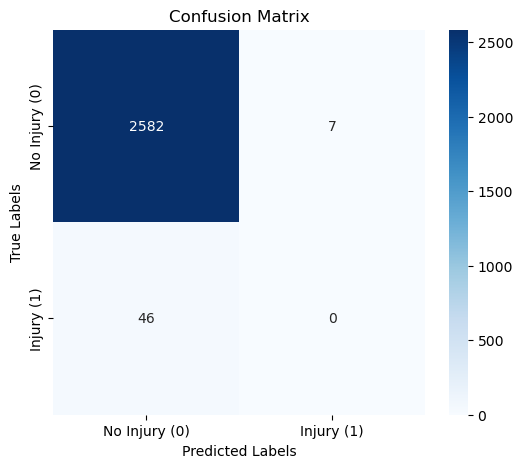

In [22]:
# Get model predictions on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_true.extend(y_batch.numpy())
        y_pred_batch = model(X_batch).squeeze()
        y_pred.extend((y_pred_batch >= 0.5).float().numpy())  # Convert to 0 or 1

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Injury (0)', 'Injury (1)'], yticklabels=['No Injury (0)', 'Injury (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()